# Introduction

## Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import glob
import os
import getpass
import sqlalchemy
#import geoalchemy2
import sys
import itertools

#import peakutils

import statsmodels.api as sm
from scipy.fftpack import fft

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
#from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
#from sklearn.preprocessing import normalize
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm


from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

#from shutil import copyfile
import pastas as ps

import io
import requests

import platform
from matplotlib import rcParams

import folium

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl,plot_mpl
import plotly.graph_objs as go

import pyproj

init_notebook_mode(connected=True)

from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import geopandas as gpd

import wellapplication as wa

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
from sklearn.preprocessing import normalize
from statsmodels.tsa.arima_model import ARIMA


rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42

In [2]:
llpath = "G:/My Drive/Python/Pycharm/loggerloader/"
sys.path.append(llpath)
import loggerloader as ll

## Database Connection

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)
engine = dbconnect.postconn_ugs()

In [12]:
def calc_wat_year(df):
    df.loc[:,'month'] = df.index.month
    df.loc[:,'year'] = df.index.year
    df.loc[:,'doy'] = df.index.dayofyear
    df['water year'] = df.index.shift(-9,freq='M').year+1
    df['ones'] = 1
    df['water year doy'] = df['ones'].groupby(df['water year']).cumsum()
    df['doylen'] = df['ones'].groupby(df['water year']).count()
    df['water year doy1'] = df.apply(lambda df: df['doy']-273 if df['water year'] > df['year'] else df['doy']+92,1)
    return df

## File Location

In [4]:
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"

# Climate Data

## USGS Data

In [7]:
trout_creek = "https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10172870"
warm_creek = "https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10172860"
flow_data = wa.nwis('dv',[10172870,10172860],'sites')

warm = flow_data.data.loc['10172860']
trout = flow_data.data.loc['10172870']

connection successful


In [8]:
flow_data.sites

,site_no,dec_lat_va,dec_long_va,dec_coord_datum_cd,station_nm,data_type_cd
0,10172860,39.459528,-114.023722,EPSG:4326,"WARM CREEK NEAR GANDY, UT",SP
1,10172870,39.744108,-113.889995,EPSG:4326,"TROUT CREEK NEAR CALLAO, UT",ST


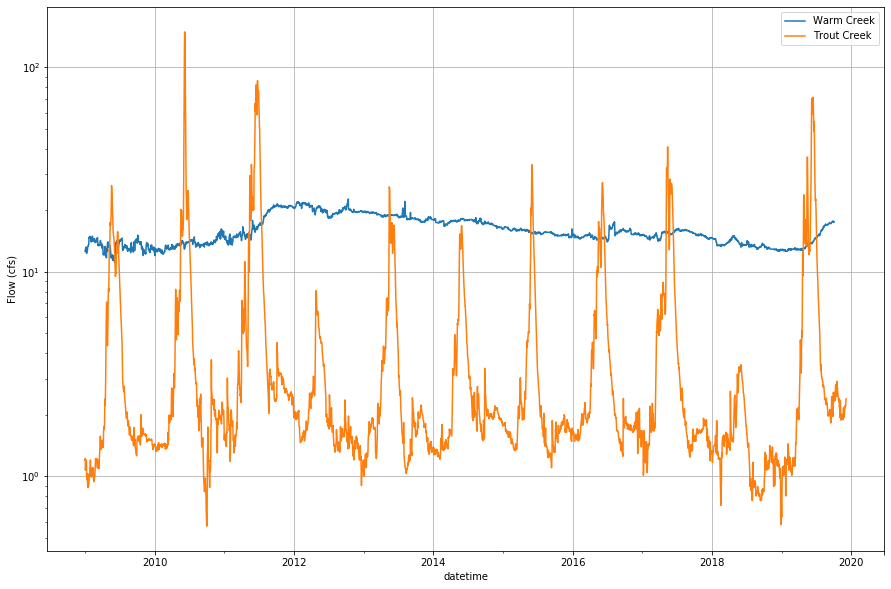

In [228]:
trout = trout[trout.index >= pd.to_datetime('2009-01-01')]
warm = warm[warm.index >= pd.to_datetime('2009-01-01')]
warm.value.plot(label='Warm Creek')
trout.value.plot(label = 'Trout Creek')
plt.ylabel('Flow (cfs)')
plt.yscale('log')
plt.grid()
plt.legend()

In [229]:
trout.columns = ['trout_qual','trout_val']
warm.columns = ['warm_qual','warm_val']

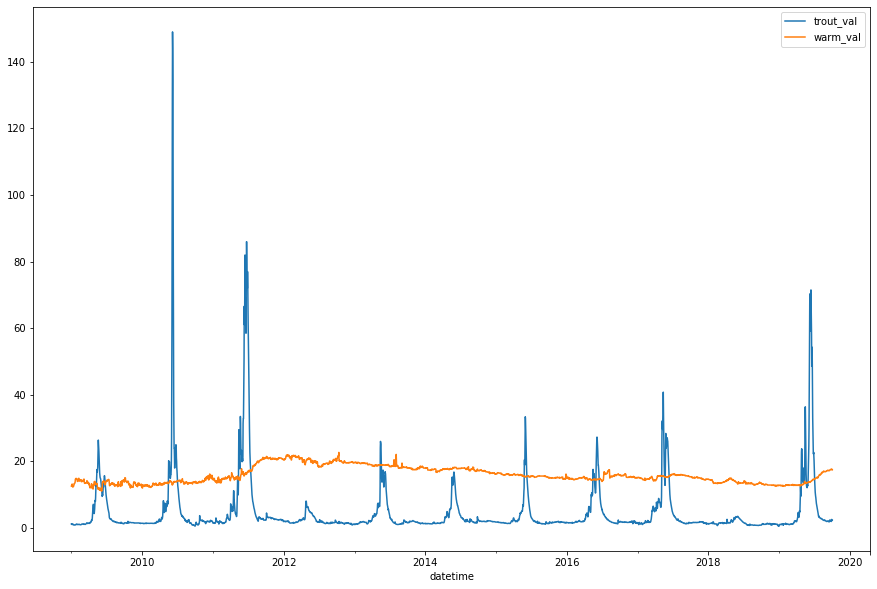

In [230]:
usgs_flow = pd.merge(trout,warm,left_index=True,right_index=True)
usgs_flow.plot()
usgs_flow.to_csv(file_place + "usgs_creeks.csv")
usgs_flow.to_pickle(file_place + "usgs_flow.pickle")
#usgs_flow.to_sql("usgs",engine,if_exists='append')

## UCC Data

In [66]:
uccdir = 'G:/My Drive/WORK/Leland_Harris/climate_data/UCC/2019_12'
uccghcn = {}
uccscan = {}
statinfo = {}
for file in glob.glob(uccdir+'/*.csv'):
    base = os.path.basename(file).split('_')
    statinfo[base[2]] = pd.read_csv(file,skiprows=[0],nrows=8,index_col=0).T
    
    if 'ghcn' in base[1]:
        uccghcn[base[2]] = pd.read_csv(file, index_col=0, skiprows=15, na_values=['S','M','T'] ,parse_dates=True)
    if 'scan' in base[1]:
        uccscan[base[2]] = pd.read_csv(file, index_col=0, skiprows=14, na_values=['S','M','T'] ,parse_dates=True)
    
ucc_ghcn_dat = pd.concat(uccghcn)
ucc_scan_dat = pd.concat(uccscan)
ucc_stats = pd.concat(statinfo)
ucc_scan_dat.to_pickle(file_place + 'ucc_scan_climate_data.pickle')
ucc_ghcn_dat.to_pickle(file_place + 'ucc_ghcn_climate_data.pickle')
ucc_stats.to_pickle(file_place + 'ucc_stat_info.pickle')

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning:

tzname MST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



In [77]:
ucc_ghcn_dat.columns

Index(['Precipitation', 'Multi-Day Precipitation', 'Snow Depth', 'Snow Fall',
       'Min Temperature', 'Max Temperature', 'Ref Evapotranspiration'],
      dtype='object')

In [225]:
def calc_wat_year(df):
  df.loc[:,'month'] = df.index.month
  df.loc[:,'year'] = df.index.year
  df.loc[:,'doy'] = df.index.dayofyear
  
  df['water year'] = df.index.shift(-9,freq='M').year+1
  df['ones'] = 1
  df['water year doy'] = df['ones'].groupby(df['water year']).cumsum()
  df['doylen'] = df['ones'].groupby(df['water year']).count()
  df['water year doy1'] = df.apply(lambda df: df['doy']-273 if df['water year'] > df['year'] else df['doy']+92,1)
  return df

Text(0.5, 1.0, 'Avg. Monthly Precipitation at Partoun')

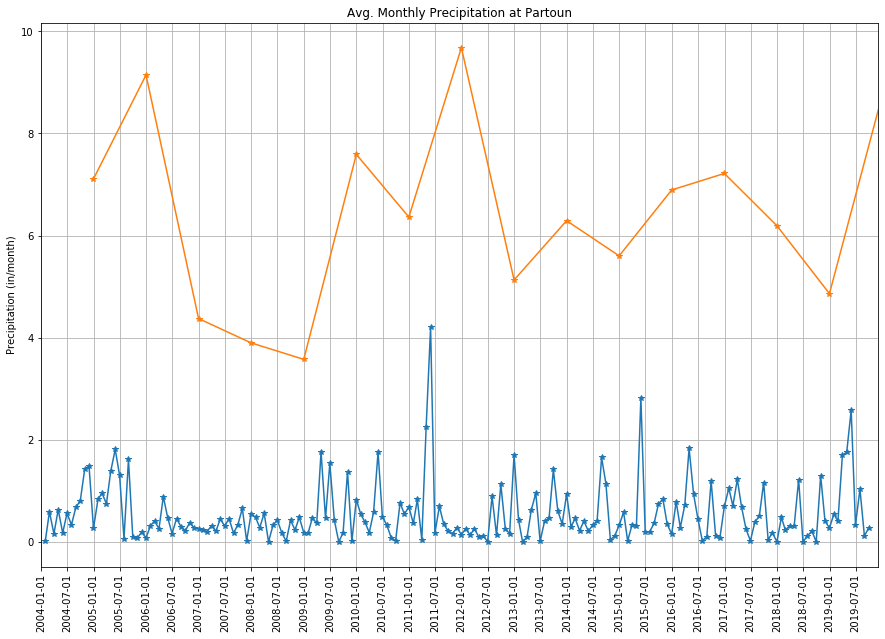

In [158]:
y = ucc_ghcn_dat.loc['USC00421144','Precipitation'].loc['2004-01-01':].groupby(pd.Grouper(freq='1M')).sum()*0.0393701
x = ucc_ghcn_dat.loc['USC00421144','Precipitation'].loc['2004-01-01':].groupby(pd.Grouper(freq='1M')).sum().index
y1 = ucc_ghcn_dat.loc['USC00421144','Precipitation'].loc['2004-01-01':].groupby(pd.Grouper(freq='1Y')).sum()*0.0393701
x1 = ucc_ghcn_dat.loc['USC00421144','Precipitation'].loc['2004-01-01':].groupby(pd.Grouper(freq='1Y')).sum().index

plt.plot(x,y,'-*',label='Monthly Average')
plt.plot(x1,y1,'-*',label='Yearly Average')
plt.xlim(prism.first_valid_index(),prism.last_valid_index())
plt.xticks(pd.date_range(prism.first_valid_index(),prism.last_valid_index(),freq='6MS'),rotation=90)
#plt.yticks(np.arange(0,5,0.5))
#plt.ylim(0,4.5)
plt.grid()
plt.ylabel('Precipitation (in)')
plt.title('Avg. Precipitation at Partoun')


## Station and PRISM Data

In [31]:
climdir = 'G:/My Drive/WORK/Leland_Harris/climate_data/'
prismraw = {}
stat_meta = {}
stat_data = {}
PPULL = pd.read_csv(climdir+'PPULL.csv',header=None,names=['latitude','longitude','Name'])
PPULL['longitude'] = PPULL['longitude'].apply(lambda x: round(float(x),4),1) 
nlookup = PPULL.set_index('longitude').to_dict()['Name']

for file in glob.glob(climdir+'/*.csv'):
    base = os.path.basename(file)
    if 'PRISM' in base:
        
        ln = float(base.split('_')[-1][:-4])
        lt = float(base.split('_')[-2])
        name = nlookup.get(ln,'mountains')
        prismraw[name] =  pd.read_csv(file,skiprows=10,parse_dates=['Date'])
        
    elif 'PPULL' in base:
        pass
    else:
        stat_file = pd.read_csv(file,skiprows=[0],nrows=8,index_col=0).T
        stat_id = stat_file.loc[stat_file.index[0],'Station ID']
        stat_meta[stat_id] = stat_file
        stat_data_file = pd.read_csv(file,skiprows=14,na_values=['M','T','S'])
        stat_data_file = stat_data_file.set_index('Day')
        stat_data_file.index = pd.to_datetime(stat_data_file.index)
        stat_data[stat_id] = stat_data_file
        
prism = pd.concat(prismraw).reset_index().rename(columns={'level_0':'Name'}).set_index(['Name','Date']).drop(['level_1'],axis=1).sort_index()
prism['ppt (in)'] = prism['ppt (mm)']*0.0393701
prism.to_pickle(file_place+'prism_data.pickle')

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning:

tzname MST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



Text(0, 0.5, 'Precipitation (in)')

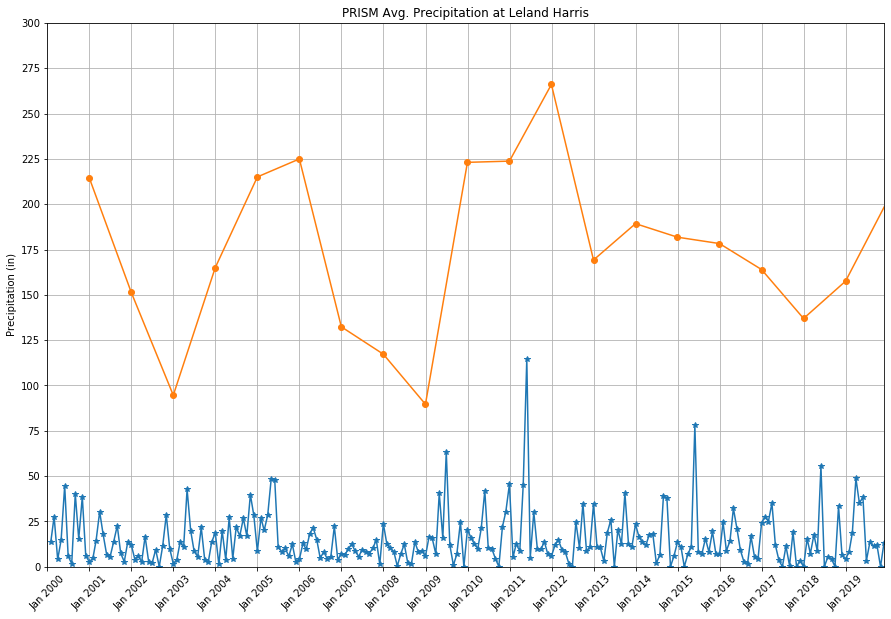

In [32]:
mopptprism = prism.loc['SG25A','ppt (mm)'].groupby(pd.Grouper(freq='1M')).sum()
yrpptprism = prism.loc['SG25A','ppt (mm)'].groupby(pd.Grouper(freq='1Y')).sum()
plt.plot(mopptprism.index,mopptprism,'-*',label='Monthly Sum')
plt.plot(yrpptprism.index,yrpptprism,'-o',label='Yearly Sum')
first_date = prism.loc['SG25A'].first_valid_index()
last_date = prism.loc['SG25A'].last_valid_index()
plt.xlim(first_date, last_date)
tickdates = pd.date_range(first_date, last_date,freq='1YS')
plt.xticks(tickdates,[i.strftime('%b %Y') for i in tickdates],rotation=45)
plt.yticks(np.arange(0,325,25))
plt.ylim(0,300)
plt.grid()
plt.title('PRISM Avg. Precipitation at Leland Harris')
plt.ylabel('Precipitation (in)')

In [33]:
st_df = pd.concat(stat_data,sort=False)
st_mt_df = pd.concat(stat_meta,sort=False)

st_mt_df = st_mt_df.reset_index().drop(['level_1'],axis=1).set_index('level_0')#[['Latitude','Longitude','Station ID']]
#usgs_sites = flow_data.sites[['dec_lat_va','dec_long_va','site_no']].rename(columns = {'dec_lat_va':'Latitude',
##                                                                                      'dec_long_va':'Longitude',
#                                                                                      'site_no':'Station ID'})


prism_precip = prism['ppt (mm)'].reset_index().groupby(['Name','Date']).mean().unstack(level=0)
prism_precip_stats = prism_precip.loc[prism_precip.index[-13]:]
prism_ppt = prism_precip.loc[:prism_precip.index[-14]]

prism_ppt.index = pd.to_datetime(prism_ppt.index)
prism_ppt.columns = prism_ppt.columns.droplevel(0)

In [34]:
rename_dict = {'Surface Wind Speed':'Wind_Speed', 'Wind Gust':'Wind_Gust', 'Wind Direction ':'Wind_Direction', 
               'Weather Conditions':'Weather_Conditions', 'Temperature Low (6 Hour)':'Temp_Low_6hr',
               'Temperature High (6 Hour)':'Temp_high_6hr', 'Precipitation (6 Hour)':'Precip_6hr',
               'Precipitation (1 Hour)':'Precip_1hr', 'Sea Level Pressure':'Sea_Level_Pressure', 
               'Dew Point':'Dew_point','Relative Humidity':'Relative_humidity', 
               'Snow Depth':'Snow_Depth', 'Quality.1':'Quality_1', 'Source.1':'Source_1',
               'Snow Fall':'Snow_Fall', 'Quality.2':'Quality_2', 'Source.2':'Source_2', 
               'Min Temperature':'Min_Temp', 'Quality.3':'Quality_3', 'Source.3':'Source_3',
               'Max Temperature':'Max_Temp', 'Quality.4':'Quality_4', 'Source.4':'Source_4', 
               'Ref Evapotranspiration':'Ref_ET'}
st_df_renm = st_df.rename(columns=rename_dict)

st_df_renm = st_df_renm.dropna(how='all')

st_mt_df['Latitude'] = pd.to_numeric(st_mt_df['Latitude'])
st_mt_df['Longitude'] = pd.to_numeric(st_mt_df['Longitude'])
crs = {'init': 'epsg:4326'}
st_mt_gdf = gpd.GeoDataFrame(st_mt_df, crs=crs,
                                geometry = gpd.points_from_xy(st_mt_df['Longitude'],st_mt_df['Latitude']))
#st_mt_gdf = st_mt_gdf.drop(['geom'],axis=1)


In [249]:
st_mt_df.to_csv(file_place+'climate_station_metadata1.csv')
st_mt_df.to_pickle(file_place+'climate_station_metadata1.pickle')
st_df.to_pickle(file_place+'climate_station_data1.pickle')

In [88]:
prism = pd.read_pickle(file_place+'prism_data.pickle')
prism = prism.drop(['ppt (in)'],axis=1)
replacebase = {'tmin ':'mintemp','tmax ':'maxtemp','tmean ':'meantemp','tdmean ':'tdmean'}
for col in prism.columns:
    colbase = col.split('(')[0]
    if 'degrees C' in col:
        prism = prism.rename(columns={col:'PRISM_{}_deg_C'.format(replacebase.get(colbase))})
    elif 'hPa' in col:
        prism = prism.rename(columns={col:f'PRISM_{colbase}_hpa'})
    elif '(mm)' in col:
        prism = prism.rename(columns={col:f'PRISM_{colbase}_mm'})
    else:
        prism = prism.rename(columns={col:f'PRISM_{colbase}'})
prismloc = prism.loc['SG25A']
prismloc.to_pickle(file_place+'prism_local_SG25.pickle')

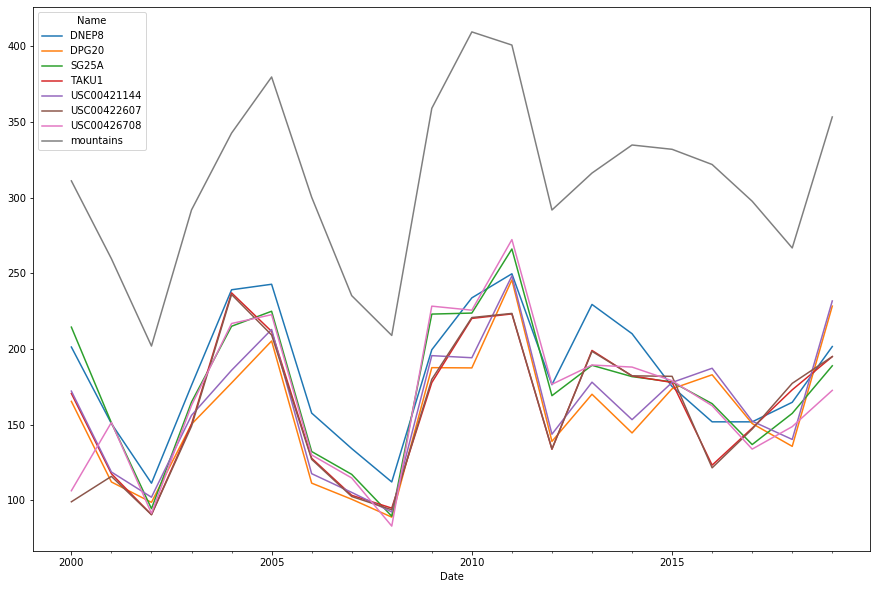

In [56]:
prism_ppt.groupby(pd.Grouper(freq='1Y')).sum().plot()

## Snotel Data

In [5]:
sntlrpt = "https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport,metric/daily/start_of_period/1147:NV:SNTL%7C1247:UT:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/stationId,name,TAVG::value,TOBS::value,BATT::value,PREC::value,PRCP::value,PRCPSA::value,SAL:-2:value,SAL:-8:value,SAL:-20:value,SNWD::value,WTEQ::value,SMS:-2:value,SMS:-8:value,SMS:-20:value,STO:-2:value,STO:-8:value,STO:-20:value?fitToScreen=false"
sntl = pd.read_csv(io.StringIO(requests.get(sntlrpt).text),skiprows=68,index_col='Date')

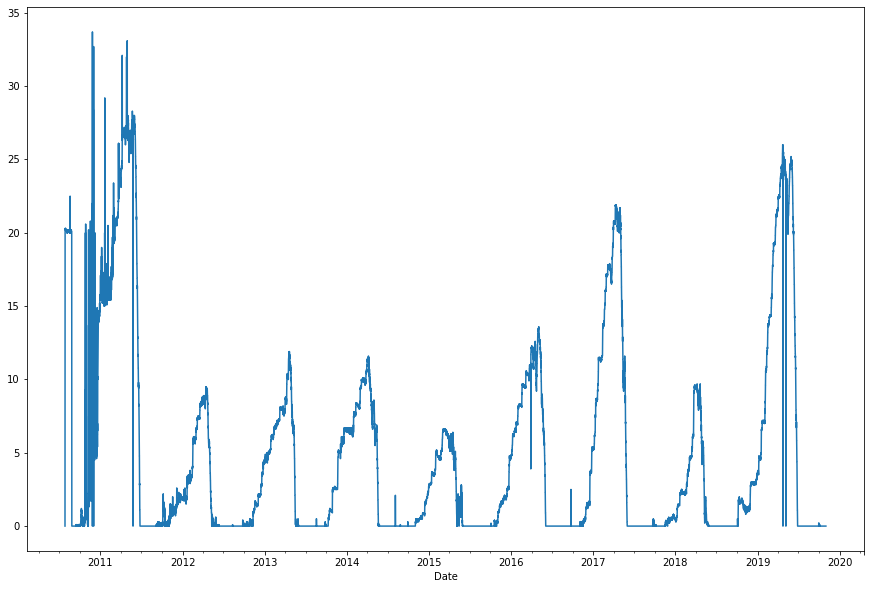

In [9]:
sntlrpthrly = 'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/hourly/start_of_period/1147:NV:SNTL|id=%22%22|name/2010-01-01,2019-10-31/WTEQ::value,SNWD::value,PREC::value,SMS:-20:value,TOBS::value,TAVG::value'
sntlhrly = pd.read_csv(io.StringIO(requests.get(sntlrpthrly).text),skiprows=57,index_col='Date',parse_dates=['Date'])
sntlhrly['swe'] = sntlhrly['Snow Water Equivalent (in)'].apply(lambda x: 0 if x<0  or x > 35 else x,1)
sntlhrly = sntlhrly.resample('1H').mean().interpolate(method='time')
sntlhrly.to_pickle(file_place+"wheeler_snotel.pickle")
sntlhrly['swe'].plot()

,Snow Water Equivalent (in),Snow Depth (in),Precipitation Accumulation (in),Soil Moisture Percent -20in (pct),Air Temperature Observed (degF),Air Temperature Average (degF),swe,month,year,doy,water year,ones,water year doy,doylen,water year doy1
Date,,,,,,,,,,,,,,,
2010-07-27 12:00:00,0.0,0.0,0.0,6.0,NaN,NaN,0.0,7,2010,208,2010,1,1,NaN,300.0
2010-07-27 13:00:00,20.2,-174.0,43.3,5.3,NaN,NaN,20.2,7,2010,208,2010,1,2,NaN,300.0
2010-07-27 14:00:00,20.2,-175.0,43.3,5.6,NaN,NaN,20.2,7,2010,208,2010,1,3,NaN,300.0
2010-07-27 15:00:00,20.2,-174.0,43.4,5.6,NaN,NaN,20.2,7,2010,208,2010,1,4,NaN,300.0
2010-07-27 16:00:00,20.2,-175.0,43.4,5.6,NaN,NaN,20.2,7,2010,208,2010,1,5,NaN,300.0


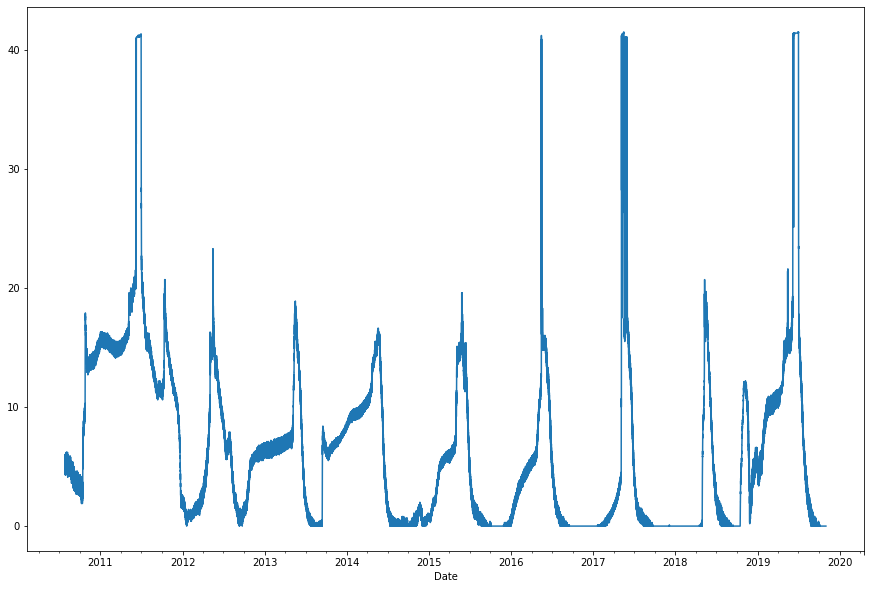

In [25]:
sntlhrly['Soil Moisture Percent -20in (pct)'].plot()

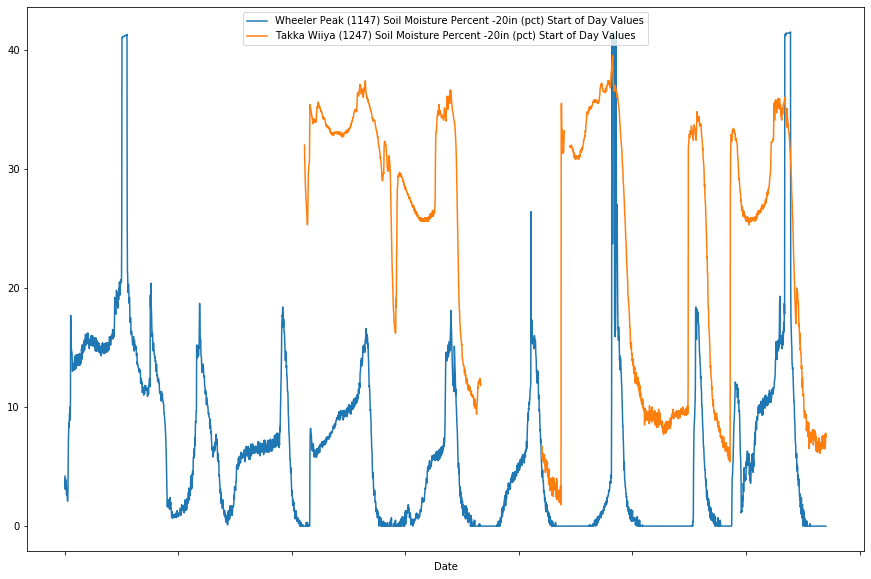

In [252]:
sntl['Wheeler Peak (1147) Soil Moisture Percent -20in (pct) Start of Day Values'].plot()
sntl['Takka Wiiya (1247) Soil Moisture Percent -20in (pct) Start of Day Values'].plot()
plt.legend()
#plt.yscale()

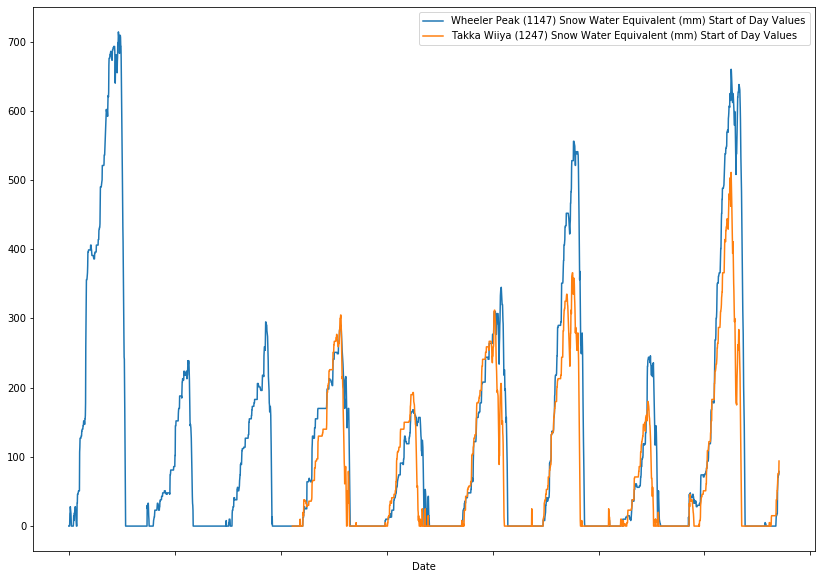

In [253]:
plt.figure(figsize=(14,10))
sntl['Wheeler Peak (1147) Snow Water Equivalent (mm) Start of Day Values'].plot()
sntl['Takka Wiiya (1247) Snow Water Equivalent (mm) Start of Day Values'].plot()
plt.legend()

In [15]:
sntl.index = pd.to_datetime(sntl.index)

In [23]:
sntlwy = calc_wat_year(sntl)
snowwymax = sntlwy.groupby('water year').max()
snowwymax.to_clipboard()

In [22]:
sntlwy

,Takka Wiiya (1247) Air Temperature Average (degC),Takka Wiiya (1247) Air Temperature Observed (degC) Start of Day Values,Takka Wiiya (1247) Battery (volt) Start of Day Values,Takka Wiiya (1247) Precipitation Accumulation (mm) Start of Day Values,Takka Wiiya (1247) Precipitation Increment (mm),Takka Wiiya (1247) Precipitation Increment - Snow-adj (mm),Takka Wiiya (1247) Salinity -2in (gram/l) Start of Day Values,Takka Wiiya (1247) Salinity -8in (gram/l) Start of Day Values,Takka Wiiya (1247) Salinity -20in (gram/l) Start of Day Values,Takka Wiiya (1247) Snow Depth (cm) Start of Day Values,...,Wheeler Peak (1147) Soil Temperature Observed -8in (degC) Start of Day Values,Wheeler Peak (1147) Soil Temperature Observed -20in (degC) Start of Day Values,month,year,doy,water year,ones,water year doy,doylen,water year doy1
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.2,8.6,10,2010,274,2011,1,1,NaN,1.0
2010-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.6,8.9,10,2010,275,2011,1,2,NaN,2.0
2010-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.3,8.9,10,2010,276,2011,1,3,NaN,3.0
2010-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.9,8.8,10,2010,277,2011,1,4,NaN,4.0
2010-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.5,8.0,10,2010,278,2011,1,5,NaN,5.0
2010-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.2,6.7,10,2010,279,2011,1,6,NaN,6.0
2010-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.1,5.6,10,2010,280,2011,1,7,NaN,7.0
2010-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.8,4.9,10,2010,281,2011,1,8,NaN,8.0
2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,4.5,10,2010,282,2011,1,9,NaN,9.0


In [254]:
sntl.to_pickle(file_place+'snotel_data.pickle')

## Precip Comparison

In [257]:
prism_ppt

Name,DNEP8,DPG20,SG25A,TAKU1,USC00421144,USC00422607,USC00426708,mountains
Date,,,,,,,,
2000-01-01,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-02,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-03,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-04,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-05,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-06,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-07,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-08,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
2000-01-09,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00


USW00053138
USC00263340
USC00421144
USC00422607
USC00424174
USC00426708
USR0000BRIM
USR0000NCED
USR0000NMAT
USR0000TULE
USS0014K07S
USS0014L04S
2165
2163
2164


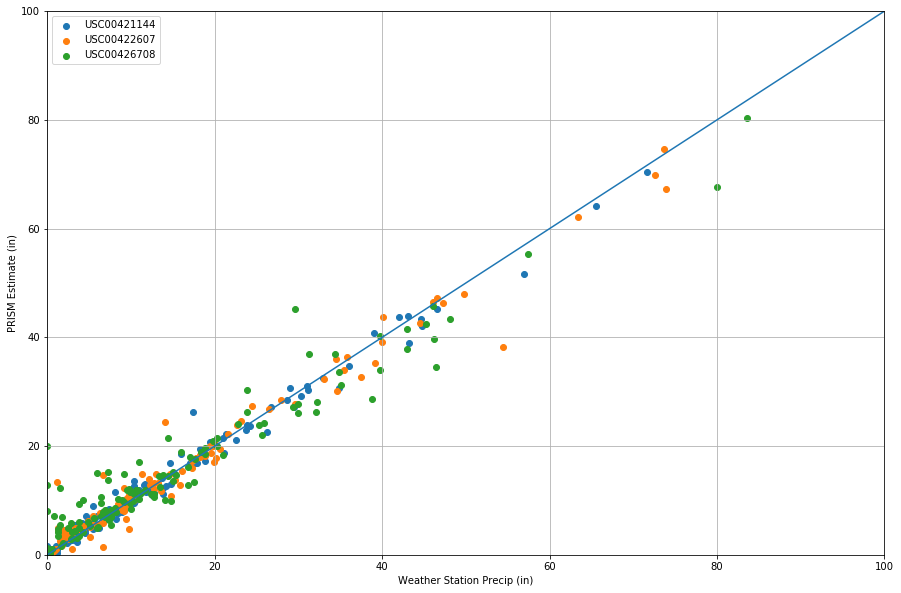

In [256]:
rcParams['figure.figsize'] = 15, 10
sts = {}

for key, value in stat_data.items():
    print(key)
    if "Precipitation" in stat_data[key].columns:
        pptcol = "Precipitation"
    elif "Precipitation (6 Hour)" in stat_data[key].columns:
        pptcol = "Precipitation (6 Hour)"
    if key in prism_ppt.columns:
        sts[key] = pd.concat([stat_data[key].loc['2008-01-01':,pptcol].resample('1D').first(),
                       prism_ppt[key]],axis=1)

        sts[key] = sts[key].dropna()
        sts[key] = sts[key].rename(columns={pptcol:'station_precip', key:'prism_precip'})
        stsgrp = sts[key].groupby(pd.Grouper(freq='1M')).sum()
        plt.scatter(stsgrp['station_precip'], stsgrp['prism_precip'], label=key)
plt.grid()
plt.xlabel('Weather Station Precip (in)')
plt.ylabel('PRISM Estimate (in)')
plt.xlim(0,100)
plt.ylim(0,100)
xn = range(0,220)
plt.legend()
plt.plot(xn,xn)
plt.savefig(file_place + "precip_compare.pdf")

## Indices

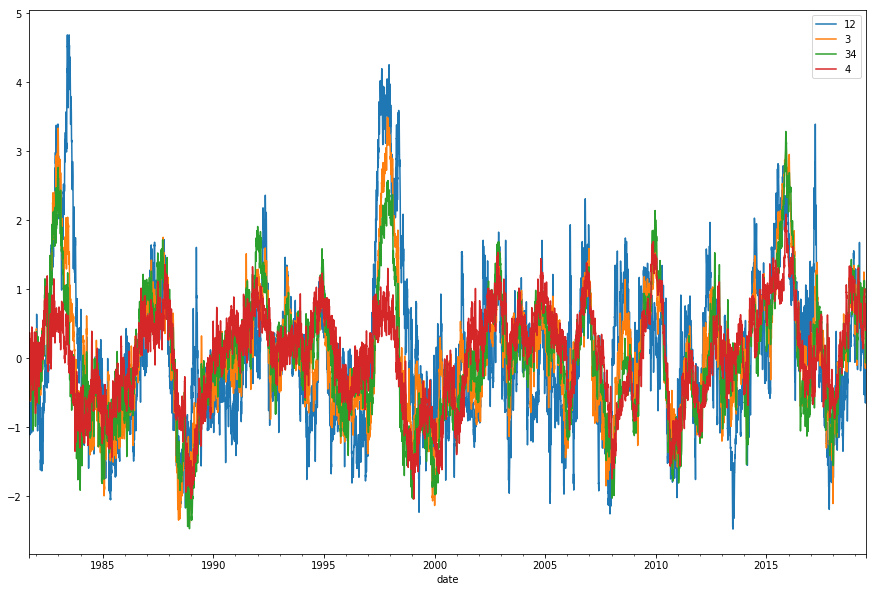

In [56]:
# El Nino (ENSO) Indices
datasets = ['3','12','4','34']
nino = {}
for i in datasets:
    nino[i] = pd.read_csv("https://climexp.knmi.nl/data/inino{:}_daily.dat".format(i),
                          sep='\s+', skiprows=11, names=['date','index'], parse_dates=['date'], index_col=0)
    nino[i] = nino[i].sort_index()
nino_df = pd.concat(nino).sort_index()
nino = nino_df.unstack(0)
nino.columns = nino.columns.droplevel()
nino.plot()
#nino.to_csv(fileloc+"enso_daily_compilation.csv")

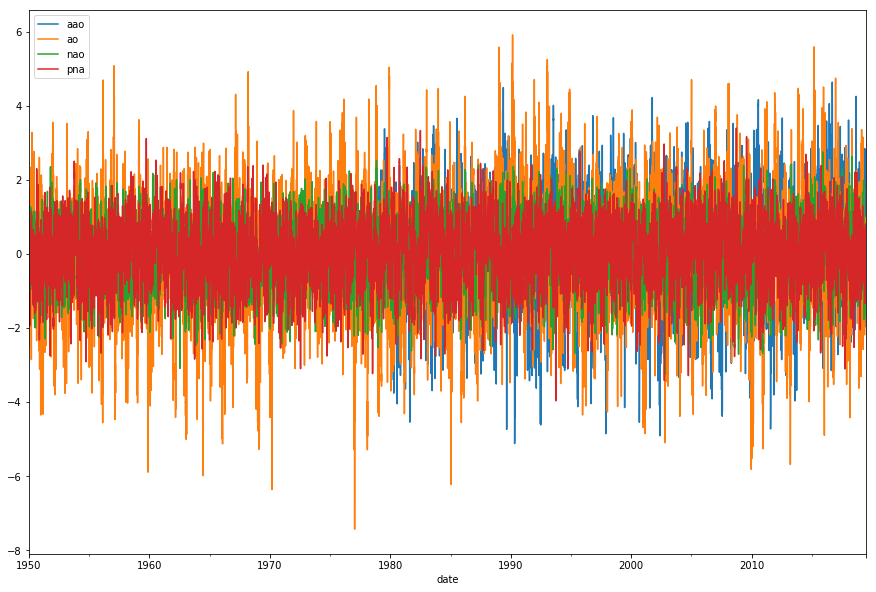

In [57]:
# Circulation Indices
circulat = ['pna','aao','ao','nao']
circ = {}
for i in circulat:
    circ[i] = pd.read_csv("https://climexp.knmi.nl/data/icpc_{:}_daily.dat".format(i),
                          sep='\s+', skiprows=7, names=['year','month','day','index'], 
                          parse_dates={'date':['year','month','day']}, index_col='date')
    circ[i] = circ[i].sort_index()
circ_df = pd.concat(circ).sort_index()
circ_df = circ_df.unstack(0)
circ_df.columns = circ_df.columns.droplevel()
circ_df.plot()

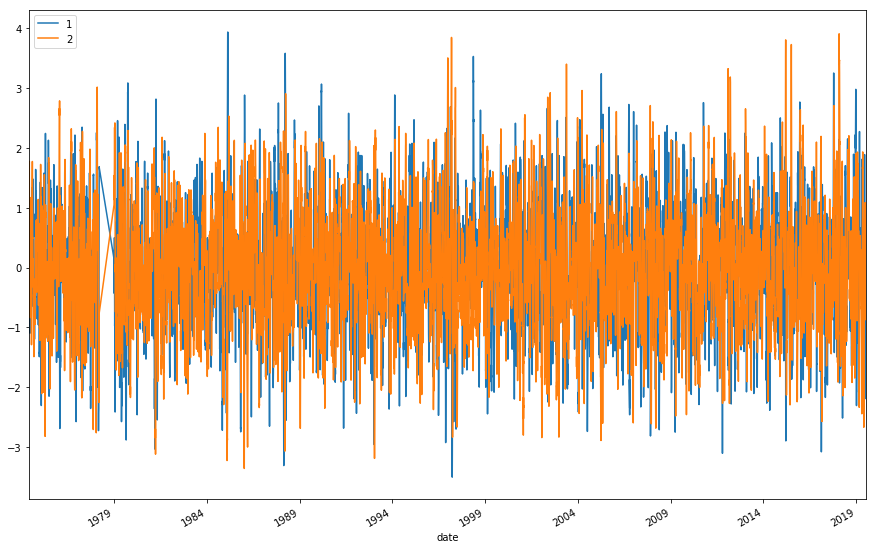

In [58]:
#MJO indices

circulat = [1,2]
mjo = {}
for i in circulat:
    mjo[i] = pd.read_csv("https://climexp.knmi.nl/data/irmm{:}.dat".format(i),
                          sep='\s+', skiprows=2, names=['year','month','day','index'], 
                          parse_dates={'date':['year','month','day']}, index_col='date')
    mjo[i] = mjo[i].sort_index()
mjo_df = pd.concat(mjo).sort_index()
mjo_df = mjo_df.unstack(0)
mjo_df.columns = mjo_df.columns.droplevel()
mjo_df.plot()

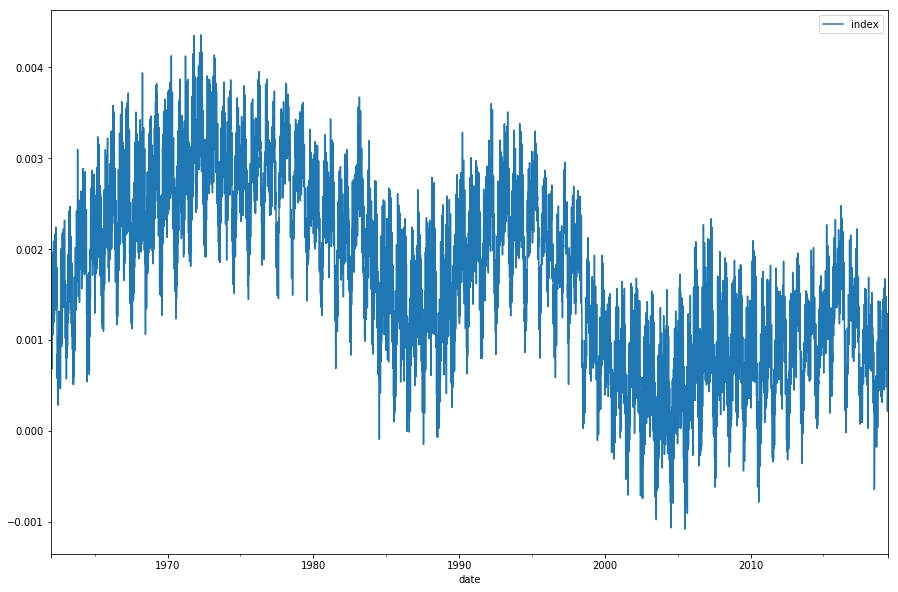

In [59]:
lodlink = "https://climexp.knmi.nl/data/ilod.dat"
lod = pd.read_csv(lodlink, sep='\s+', skiprows=10, names=['year','month','day','index'], 
            parse_dates={'date':['year','month','day']}, index_col='date')
lod.plot()

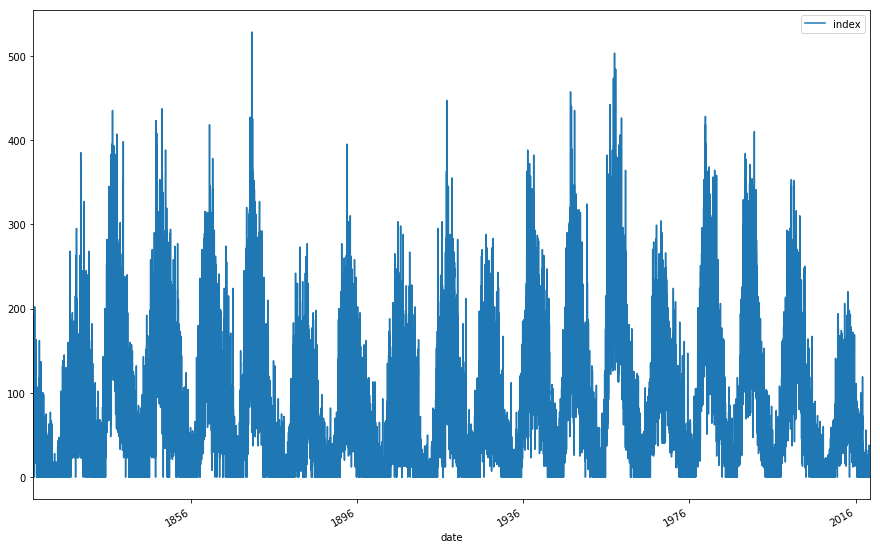

In [60]:
sunspotslink = "https://climexp.knmi.nl/data/isunspots_daily.dat"

spots = pd.read_csv(sunspotslink, sep='\s+', skiprows=8, names=['year','month','day','index'], 
            parse_dates={'date':['year','month','day']}, index_col='date')
spots.plot()

In [61]:
circ_df.columns = ['circ_aao','circ_ao','circ_nao','circ_pna']
nino.columns = ['nino_12','nino_3','nino_34','nino_4']
lod.columns = ['lod_index']
mjo_df.columns = ['mjo_1','mjo_2']
spots.columns = ['nospots']

In [62]:
climate_indices = pd.concat([lod,mjo_df,circ_df,nino,spots],axis=1)

In [63]:
climate_indices.to_pickle(file_place + 'climate_indices.pickle')
climate_indices.to_csv(file_place + 'climate_indices.csv')


## UGS Climate Station

In [6]:
ugs_climate_dir = "G:/My Drive/WORK/Leland_Harris/climate_data/UGS_Station/"
ugs_climate_loc_0 = ugs_climate_dir + "UGS_Snake_Valley_Weather_Station_0.csv"
ugs_climate_loc_1 = ugs_climate_dir + "UGS_Snake_Valley_Weather_Station_1.csv"


ugs_clim_raw_0 = pd.read_csv(ugs_climate_loc_0, skiprows=1)
ugs_clim_raw_1 = pd.read_csv(ugs_climate_loc_1, skiprows=1)
ugs_clim_raw = pd.concat([ugs_clim_raw_0,ugs_clim_raw_1])
ugs_clim_raw.index = pd.to_datetime(ugs_clim_raw['Date Time, GMT-07:00'])
ugs_clim_raw.index = ugs_clim_raw.index.tz_localize('MST')

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [7]:
locclim = {'#':'numb', 
           'Date Time, GMT-07:00':'datetime',
           'Temp, °F (LGR S/N: 20077753, SEN S/N: 10869187, LBL: AirTemperature)':'air_temp',
           'RH, % (LGR S/N: 20077753, SEN S/N: 10869187, LBL: Humidity)':'RH',
           'Water Content, m³/m³ (LGR S/N: 20077753, SEN S/N: 10881810, LBL: Soil Moisture)':'soil_moisture',
           'Temp, °F (LGR S/N: 20077753, SEN S/N: 10883570, LBL: Soil Temp)':'soil_temp',
           'Rain, in (LGR S/N: 20077753, SEN S/N: 20067089, LBL: Precip)':'precip',
           'PAR, µmol/m²/s (LGR S/N: 20077753, SEN S/N: 20082571, LBL: PAR1)':'PAR1',
           'PAR, µmol/m²/s (LGR S/N: 20077753, SEN S/N: 20082572, LBL: PAR2)':'PAR2',
           'Solar Radiation, W/m² (LGR S/N: 20077753, SEN S/N: 20089743, LBL: SolarRadiation1)':'SolarRadiation1',
           'Solar Radiation, W/m² (LGR S/N: 20077753, SEN S/N: 20089744, LBL: SolarRadiation2)':'SolarRadiation2',
           'Pressure, in Hg (LGR S/N: 20077753, SEN S/N: 20093399, LBL: BarometricPressure)':'BaroPressure',
           'Wind Speed, mph (LGR S/N: 20077753, SEN S/N: 20096052, LBL: Wind Speed)':'Wind_Speed',
           'Gust Speed, mph (LGR S/N: 20077753, SEN S/N: 20096052, LBL: Gust Speed)':'Gust_Speed',
           'Wind Direction, ø (LGR S/N: 20077753, SEN S/N: 20096052, LBL: Wind Direction)':'Wind_Direction',
           'DewPt, °F (LGR S/N: 20077753, SEN S/N: 10869187)':'DewPt'}
ugs_clim_raw = ugs_clim_raw.rename(columns=locclim)

In [261]:
ugs_clim_raw.to_pickle(file_place + 'ugs_climate_station.pickle')

In [10]:
ugs_clim_raw['Gust_Speed'].last_valid_index()

Timestamp('2019-03-05 08:30:00-0700', tz='MST')

# Combine Datasets

In [51]:
ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")
wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
st_mt_df = pd.read_pickle(file_place+'climate_station_metadata1.pickle')
st_df = pd.read_pickle(file_place+'climate_station_data1.pickle')
sntl = pd.read_pickle(file_place+'snotel_data.pickle')
prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')

In [201]:
prismloc

,PRISM_ppt _mm,PRISM_mintemp_deg_C,PRISM_meantemp_deg_C,PRISM_maxtemp_deg_C,PRISM_tdmean_deg_C,PRISM_vpdmin _hpa,PRISM_vpdmax _hpa
Date,,,,,,,
2000-01-01,0.00,-10.6,-1.6,7.4,-13.7,1.02,7.97
2000-01-02,0.00,-8.3,-0.6,7.0,-9.8,0.45,7.28
2000-01-03,0.00,-9.4,-2.9,3.7,-12.6,0.72,6.13
2000-01-04,0.00,-12.0,-4.0,3.9,-12.1,0.38,5.45
2000-01-05,0.00,-7.0,-0.0,6.9,-9.2,0.95,6.39
2000-01-06,0.00,-16.6,-6.8,3.0,-12.2,0.20,5.10
2000-01-07,0.00,-13.3,-5.0,3.4,-14.7,0.61,5.55
2000-01-08,0.00,-13.1,-3.2,6.7,-9.4,0.23,6.52
2000-01-09,0.00,-12.7,-2.1,8.5,-9.4,0.22,7.68


In [192]:
m = folium.Map(location=[st_mt_df['Latitude'].mean(), st_mt_df['Longitude'].mean()],
           tiles='OpenStreetMap',
           zoom_start=10)

for site in st_mt_df.index:
    folium.Marker([st_mt_df.loc[site,'Latitude'],
                   st_mt_df.loc[site,'Longitude']],
                  popup=st_mt_df.loc[site,'Station Name']).add_to(m)
m

In [193]:
dfs = {}
for station in st_df.index.get_level_values(0).unique()[3:]:
    stname = st_mt_df.loc[station,'Station Name'].split(" ")[0].lower()

    dfs[station] = st_df.loc[station].dropna(axis=1,how='all').rename(columns={'Precipitation':f'{stname}_ppt',
                                                            'Snow Depth':f'{stname}_snowdpt',
                                                           'Snow Fall':f'{stname}_snowfall',
                                                           'Min Temperature':f'{stname}_mintemp',
                                                           'Max Temperature':f'{stname}_maxtemp',
                                                           'Ref Evapotranspiration':f'{stname}_et'})
    if 'Multi-Day Precipitation' in dfs[station].columns:
        dfs[station] = dfs[station].drop(['Multi-Day Precipitation'],axis=1)

In [194]:
weatherdata = pd.concat(dfs, axis=1)#
weatherdata.columns = weatherdata.columns.droplevel(0)
for col in weatherdata.columns:
    if 'goshute' in col or 'silver' in col or 'baker' in col or 'wheeler' in col or 'ibapah' in col or 'great' in col:
        weatherdata = weatherdata.drop(col, axis=1)

In [195]:
weatherdata.index = pd.to_datetime(weatherdata.index)

In [196]:
sntl = pd.read_pickle(file_place+'snotel_data.pickle')
for col in sntl.columns:
    if 'Salinity' in col or 'Battery' in col or 'Air Temperature' in col:
        sntl = sntl.drop(col,axis=1)

for col in sntl.columns:
    if 'Precipitation Accumulation' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_pptaccm_mm'})
    elif 'Precipitation Increment - Snow-adj' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_pptincr_mm'})
    elif 'Soil Moisture' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+col.split(" ")[6]+'_soilmoist_pct'})
    elif 'Soil Temperature' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+col.split(" ")[6]+'_soiltemp_C'})
    elif 'Snow Depth' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_snowdepth_cm'})
    elif 'Snow Water' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_swe_mm'})
    else:
        sntl = sntl.drop(col,axis=1)
sntl.index = pd.to_datetime(sntl.index)

In [197]:
climate_data = pd.concat([weatherdata.sort_index(),sntl.sort_index(),prismloc.sort_index()],axis=1,sort=True)
climate_data.to_pickle(file_place+'climate_data.pickle')

In [27]:
def climate_plotter_wy(df, keyword, exclude='soil', totaler='sum'):
    fig, ax = plt.subplots(1,1)
    dfwy = df.copy()
    dfwy = calc_wat_year(dfwy)
    for col in dfwy.columns:
        if keyword in col and exclude not in col:
            if totaler=='mean':
                dfwy = dfwy.groupby('water year').mean()
            elif totaler=='sum':
                dfwy = dfwy.groupby('water year').sum()
            else:
                dfwy = dfwy.groupby('water year').median()
            dfwy = dfwy.replace(0.0, np.nan)
            plt.plot(dfwy.index,dfwy[col]*0.0393701, label=col)
    plt.grid()
    plt.legend()
    return fig, ax, dfwy

In [25]:
climate_data = pd.read_pickle(file_place+'climate_data.pickle')

In [26]:
def climate_plotter(df, keyword, exclude='soil', frq='6M',totaler='mean'):
    fig, ax = plt.subplots(1,1)
    for col in df.columns:
        if keyword in col and exclude not in col:
            if totaler=='mean':
                df = df.groupby(pd.Grouper(freq=frq)).mean()
            elif totaler=='sum':
                df = df.groupby(pd.Grouper(freq=frq)).sum()
            else:
                df = df.groupby(pd.Grouper(freq=frq)).median()
            df = df.replace(0.0, np.nan)
            plt.plot(df.index,df[col], label=col)
    plt.grid()
    plt.legend()
    return fig, ax

Text(0, 0.5, 'Precipitation (mm)')

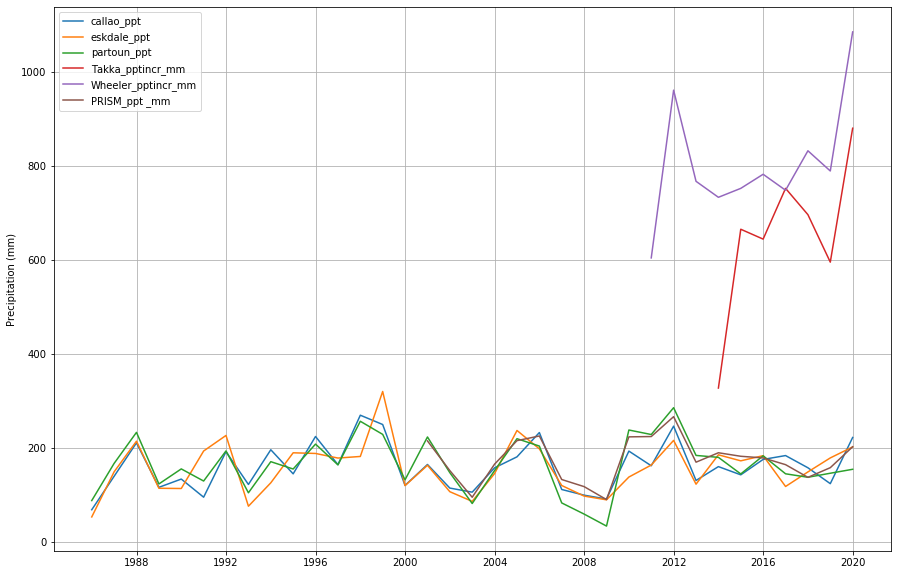

In [199]:
climate_plotter(climate_data, 'ppt','accm',frq='1Y',totaler='sum')
plt.ylabel('Precipitation (mm)')

In [57]:
ugs_clim_raw_dly.columns

Index(['numb', 'DewPt', 'Gust_Speed', 'PAR1', 'PAR2', 'BaroPressure', 'RH',
       'precip', 'SolarRadiation1', 'SolarRadiation2', 'air_temp', 'soil_temp',
       'soil_moisture', 'Wind_Direction', 'Wind_Speed', 'air_temp_c',
       'max_dly_temp', 'min_dly_temp', 'mean_dly_temp', 'tmean', 'solar_rad',
       'u2_wind', 'esslope', 'atm_press', 'psy_const', 'delta', 'psi', 'TT',
       'sat_vap_press', 'act_vap_press', 'julian', 'dr', 'declin', 'sunst_hr',
       'extra_rad', 'clear_rad', 'rns', 'net_out_rad', 'net_rad', 'net_rad_g',
       'et_rad', 'et_wind', 'et_ref'],
      dtype='object')

In [56]:
ugs_clim_raw_dly.loc['2017-10-01':'2018-09-30','precip'].sum()

2.54

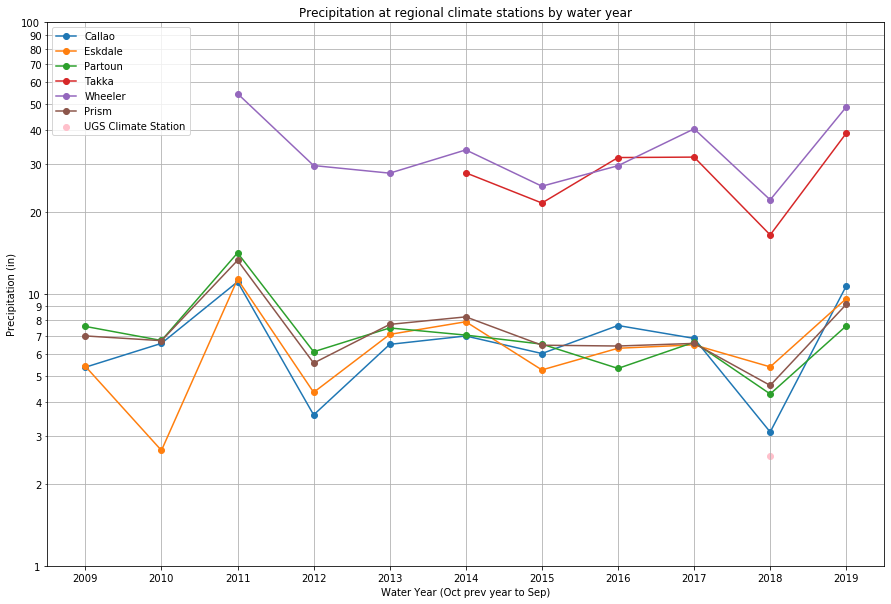

In [60]:
from matplotlib.ticker import FormatStrFormatter
cldat = climate_data.loc['2009':]

fig, ax = plt.subplots(1,1)
dfwy = cldat.copy()
dfwy = calc_wat_year(dfwy)
for col in dfwy.columns:
    if 'ppt' in col and 'accm' not in col:
        dfwy = dfwy.groupby('water year').sum()
        dfwy.loc[2013,'Takka_pptincr_mm'] = None
        dfwy = dfwy.loc[:2019]
        dfwy = dfwy.replace(0.0, np.nan)
        plt.plot(dfwy.index,dfwy[col]*0.0393701, '-o',label=col.split("_")[0].title())
plt.scatter(2018,2.54,label='UGS Climate Station',color='pink')
plt.yscale('log')
plt.grid(which='both')

ax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.ylim(1,100)
plt.legend()
plt.xticks(range(2009,2020))
plt.ylabel('Precipitation (in)')
plt.xlabel('Water Year (Oct prev year to Sep)')
plt.title('Precipitation at regional climate stations by water year')
plt.savefig("G:/Shared drives/UGS_Wetlands/Projects/Leland_Harris/Figures/wy_precip.pdf")

In [63]:
dfwy['partoun_ppt'].sort_values()

water year
2018    108.9
2016    135.2
2012    155.7
2015    166.1
2017    168.8
2010    171.3
2014    179.3
2013    190.5
2009    193.0
2019    193.9
2011    359.8
Name: partoun_ppt, dtype: float64

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c61602f6a0>)

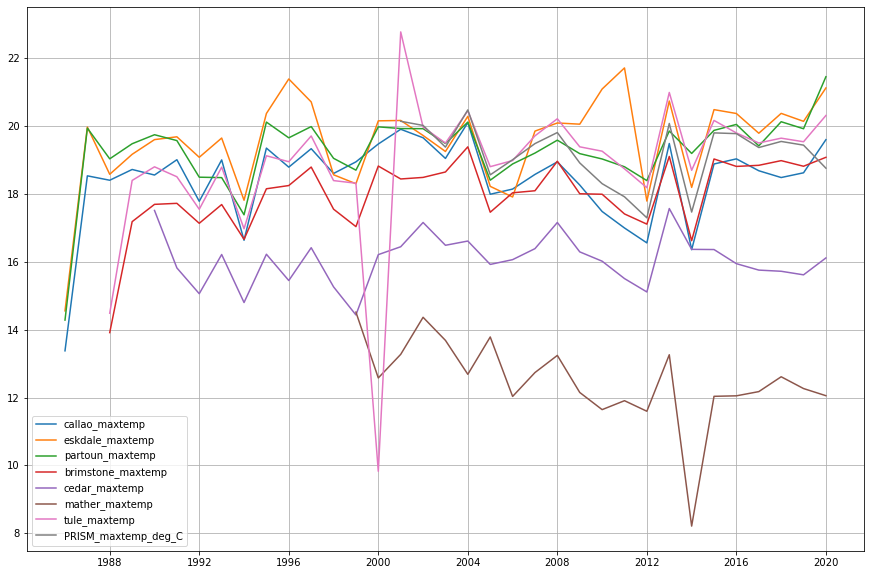

In [200]:
climate_plotter(climate_data, 'maxtemp',frq='1Y',totaler='mean')